# Reading in Results

In [1]:
import math
from bestreads import text
from bestreads.text.metrics import rbo
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
import seaborn as sbn

sbn.set_style('whitegrid')

data_dir = './data/processed/'
processed_data_train = pd.read_csv(
    data_dir + 'goodreads_books_train_processed.csv', index_col=0)
processed_data_val = pd.read_csv(
    data_dir + 'goodreads_books_val_processed.csv', index_col=0)
tf_idf_table = pd.read_csv(
    data_dir + 'tf_idf_table_train.csv', index_col=0)

In [2]:
genre_and_votes_val = processed_data_val[['genre_1', 'votes_1']]
cleaned_descriptions_val = processed_data_val['cleaned_descriptions']

In [3]:
tf_idf_table.head()

,Historical,War,Young Adult,Science Fiction Fantasy,Mystery,Spirituality,Science Fiction,Science,Thriller,Magical Realism,...,Womens,Novels,The United States Of America,Race,Childrens,Sociology,Humor,Writing,Religion,Womens Fiction
word,,,,,,,,,,,,,,,,,,,,,
ivi,0.000351,0.000014,0.000163,0.000104,0.000093,0.000000,0.000032,0.000000,0.000057,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000063
row,0.000023,0.000010,0.000047,0.000000,0.000026,0.000000,0.000037,0.000015,0.000106,0.000000,...,0.000000,0.000000,0.000000,0.000225,0.000000,0.000046,0.000000,0.000000,0.000000,0.000018
birth,0.000128,0.000051,0.000036,0.000081,0.000036,0.000052,0.000059,0.000084,0.000046,0.000034,...,0.000132,0.000036,0.000000,0.000000,0.000000,0.000049,0.000029,0.000046,0.000088,0.000048
blue,0.000036,0.000030,0.000083,0.000073,0.000063,0.000021,0.000036,0.000052,0.000049,0.000103,...,0.000000,0.000056,0.000161,0.000242,0.000566,0.000042,0.000101,0.000039,0.000022,0.000089
star,0.000047,0.000035,0.000073,0.000056,0.000068,0.000002,0.000120,0.000034,0.000053,0.000029,...,0.000047,0.000074,0.000206,0.000015,0.000032,0.000015,0.000074,0.000047,0.000014,0.000093


## Metrics

We can plot what the weighting of the rank-biased order (RBO) evaluation metric cumulative weight looks like for different choices of the parameter p.

In [4]:
# This function is a hot mess, but it calculates the fraction of the total weight in the RBO
# that is associated with the first d terms given a choice of 0 < p < 1.  Large values of p
# will give more weight to terms lower down the list while smaller values weight the top
# values more heavily.

def rbo_weight(p, d):
    def sum_series(p, d):
        # tail recursive helper function
        def helper(ret, p, d, i):
            term = math.pow(p, i)/i
            if d == i:
                return ret + term
            return helper(ret + term, p, d, i+1)
        return helper(0, p, d, 1)

    return (1 - math.pow(p, d-1) 
            + (((1-p)/p) * d *(np.log(1/(1-p))
                               - sum_series(p, d-1))))

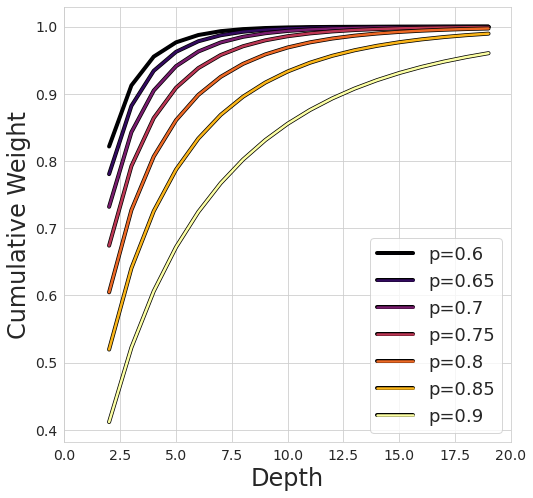

In [5]:
fig = plt.figure(figsize = (8, 8))
sp = fig.add_subplot(111)

d_grid = np.arange(18)+2
p_grid = np.arange(0.6, 0.95, 0.05)
colors = [mpl.cm.inferno(int(place)) for place in np.linspace(0, mpl.cm.inferno.N, len(p_grid))]

for p, color in zip(p_grid, colors):
    weight_list = []
    for d in d_grid:
        weight_list.append(rbo_weight(p,d))
    
    sp.plot(d_grid, weight_list, color=color, 
            path_effects=[pe.Stroke(linewidth = 4, foreground = 'k'), pe.Normal()],
            linewidth=2.5, label = f'p={p:.2}')

sp.set_xlim(0, 20)
sp.set_xlabel('Depth')
sp.set_ylabel('Cumulative Weight')
sp.legend(loc='lower right')

## Validation

In [6]:
# temp_descriptions = cleaned_descriptions_val.sample(n=100)
temp_genres = []

for rownum, row in processed_data_val.filter(like='genre').iterrows():
    temp_genres.append(row[row.notnull()].to_list())

In [7]:
rand_indices = np.random.choice(np.arange(len(temp_genres)), size=100, replace=False)
val_genres = [temp_genres[ind] for ind in rand_indices]
val_descriptions = [cleaned_descriptions_val.iloc[ind] for ind in rand_indices]

In [15]:
rbo_list = []
predictions = []
p = 0.75

for genre_list, description in tqdm(zip(val_genres, val_descriptions), total=len(val_genres)):
    result = text.query(description, tf_idf_table)
    if len(result)>0 and len(genre_list)>0:
        predictions.append(result)
        rbo_list.append(rbo(result.index, genre_list, p))

100%|█████████████████████████████████████████| 100/100 [10:38<00:00,  6.39s/it]


In [18]:
genre_list = predictions[0].index.to_numpy()
random_predictions = [np.random.choice(genre_list, size=len(genre_list), replace=False) for _ in predictions]

random_rbo_list = [rbo(rand_pred, genre_list, 0.75) for rand_pred, genre_list in zip(random_predictions, val_genres) if len(genre_list)>0]

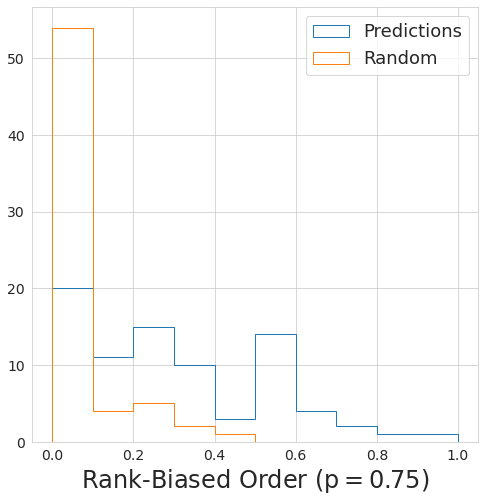

In [19]:
## Plot the histogram of RBO values

fig = plt.figure(figsize=(8, 8))
sp = fig.add_subplot(111)

sp.hist(rbo_list, range=(0, 1), histtype='step', label='Predictions')
sp.hist(random_rbo_list, range=(0, 1), histtype='step', label='Random')

sp.set_xlabel(f'Rank-Biased Order ($p={p:.2}$)')
sp.legend()